In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings

warnings.filterwarnings("ignore")

In [2]:
df= pd.read_csv("/Users/siddhant/housepriceproject/Capstone/data/processed/properties-post-feature-selection.csv")

In [3]:
df.head()

,property_type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furniture_labels,luxury_level,floor_category
0,flat,sector 56,1.99,4,4,3+,old property,2000.0,0,0,2,Medium,Mid Floor
1,flat,sector 2,0.98,2,2,3,moderately new,1416.0,0,0,0,Medium,High Floor
2,flat,sector 57,5.50,5,6,3+,moderately new,5010.0,1,0,2,High,Mid Floor
3,flat,sector 85,1.25,2,2,3,relatively new,1730.0,0,0,0,Low,Mid Floor
4,flat,sector 83,1.05,3,3,3,moderately new,1468.0,0,0,2,Medium,Mid Floor


In [4]:
df.shape

(3548, 13)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3548 entries, 0 to 3547
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   property_type     3548 non-null   object 
 1   sector            3548 non-null   object 
 2   price             3548 non-null   float64
 3   bedRoom           3548 non-null   int64  
 4   bathroom          3548 non-null   int64  
 5   balcony           3548 non-null   object 
 6   agePossession     3548 non-null   object 
 7   built_up_area     3548 non-null   float64
 8   servant room      3548 non-null   int64  
 9   store room        3548 non-null   int64  
 10  furniture_labels  3548 non-null   int64  
 11  luxury_level      3548 non-null   object 
 12  floor_category    3548 non-null   object 
dtypes: float64(2), int64(5), object(6)
memory usage: 360.5+ KB


In [6]:
df.isnull().sum()

property_type       0
sector              0
price               0
bedRoom             0
bathroom            0
balcony             0
agePossession       0
built_up_area       0
servant room        0
store room          0
furniture_labels    0
luxury_level        0
floor_category      0
dtype: int64

In [7]:
df["furniture_labels"] = df["furniture_labels"].replace({0:3})
df.rename(columns={"furniture_labels":"furniture_type"}, inplace=True)
        

In [8]:
df["furniture_type"].replace({3: 1, 1: 3, 2: 2}, inplace=True)

In [9]:
df["furniture_type"].value_counts()

furniture_type
1    2368
2     995
3     185
Name: count, dtype: int64

In [10]:
df.columns

Index(['property_type', 'sector', 'price', 'bedRoom', 'bathroom', 'balcony',
       'agePossession', 'built_up_area', 'servant room', 'store room',
       'furniture_type', 'luxury_level', 'floor_category'],
      dtype='object')

In [11]:
X = df.drop(columns="price")
y = df["price"]

In [12]:
X.head()

,property_type,sector,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furniture_type,luxury_level,floor_category
0,flat,sector 56,4,4,3+,old property,2000.0,0,0,2,Medium,Mid Floor
1,flat,sector 2,2,2,3,moderately new,1416.0,0,0,1,Medium,High Floor
2,flat,sector 57,5,6,3+,moderately new,5010.0,1,0,2,High,Mid Floor
3,flat,sector 85,2,2,3,relatively new,1730.0,0,0,1,Low,Mid Floor
4,flat,sector 83,3,3,3,moderately new,1468.0,0,0,2,Medium,Mid Floor


We will use 3 approaches. 
1. Train categorical variable with one hot encoding
2. Train categorical variables with ordinal encoding
3. Use target encoding

Create multiple models and then compare the results

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import category_encoders as ce

<Axes: xlabel='price', ylabel='Density'>

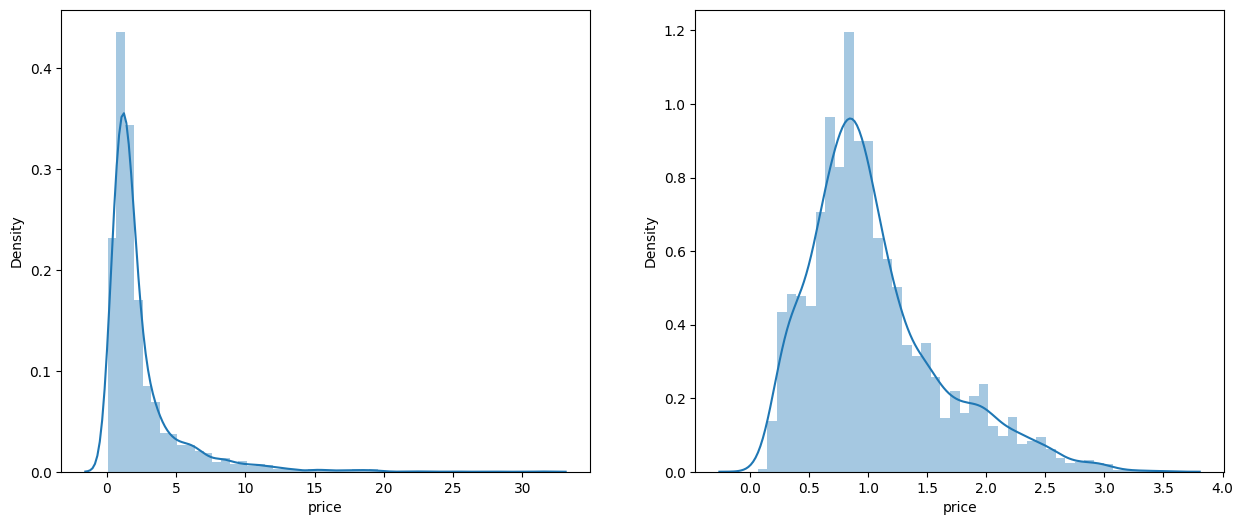

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
sns.distplot(y, ax=ax[0])
sns.distplot(np.log1p(y), ax=ax[1])

In [15]:
y_transformed = np.log1p(y)

In [16]:
X.columns

Index(['property_type', 'sector', 'bedRoom', 'bathroom', 'balcony',
       'agePossession', 'built_up_area', 'servant room', 'store room',
       'furniture_type', 'luxury_level', 'floor_category'],
      dtype='object')

In [17]:
ohe = OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False)
ordinal = OrdinalEncoder()
scaler = StandardScaler()
svr = SVR(kernel="rbf")
lr = LinearRegression()


ORDINAL ENCODING

In [19]:
columns_encode_ordinal = ['property_type','sector', 'balcony', 'agePossession', 'furniture_type', 'luxury_level', 'floor_category']
columns_scale = ['bedRoom', 'bathroom', 'built_up_area', 'servant room','store room']


# BUILDING TRANSFORMER
transform = ColumnTransformer(transformers=[
    ('scale', scaler, columns_scale),
    ('ohe', ordinal, columns_encode_ordinal)  
], remainder="passthrough")


# BUILD PIPELINE
pipeline = Pipeline([
    ('transform', transform),
    ('linear_model', lr)
])


# K-FOLDS CROSS VALIDATION
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
score = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

# CHECKING SCORE
print("Scores for each fold:", score)
mean_score = np.nanmean(score)
print("Mean Score Ignoring NaNs:", mean_score)



Scores for each fold: [0.71472763 0.73625542 0.74637115 0.75483986 0.61820045 0.74330243
        nan 0.70427768 0.74729133 0.74795506]
Mean Score Ignoring NaNs: 0.7236912237443551


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

# IMPORTANT - OUR TARGET COLUMN (Y) WAS LOG TRANSFORMED, HENCE ALL THE PREDICTIONS THAT THE MODEL MAKES ON TEST SET WOULD BE
# WITH RESPECT TO THE LOG TRANSFORMED SCALE. ONCE PREDICTION IS DONE WE NEED TO CONVERT THEM BACK TO THE ORIGINAL SCALE AS IT WAS BEFORE
# LOG TRANSFORMATION.

y_pred = np.expm1(y_pred)
y_test = np.expm1(y_test)

print(f"The mean absolute eror is: {mean_absolute_error(y_test, y_pred)}")

The mean absolute eror is: 0.9135517720123439


In [21]:
# LETS CREATE A FUNCTION TO TRAIN AND RUN ANY MODEL
def scorer(model_name, model):
    output = []
    output.append(model_name)
    
    pipeline = Pipeline([
    ('transform', transform),
    (model_name, model)
    ])

    # K-FOLDS CROSS VALIDATION
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    score = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')
    mean_score = np.nanmean(score)
    output.append(mean_score)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred = np.expm1(y_pred)
    y_test = np.expm1(y_test)

    output.append(mean_absolute_error(y_test, y_pred))
    
    return output




In [22]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'xgboost':XGBRegressor()
}

In [23]:
model_output = []
for model_name, model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [24]:
model_df = pd.DataFrame(model_output, columns=['model', 'score', 'mae']).sort_values("score", ascending=False)
model_df

,model,score,mae
9,xgboost,0.893578,0.494373
5,random forest,0.884793,0.534810
7,gradient boosting,0.874032,0.562126
6,extra trees,0.865368,0.564510
4,decision tree,0.773524,0.701203
8,adaboost,0.757050,0.834500
1,svr,0.747265,0.860349
0,linear_reg,0.723691,0.913552
2,ridge,0.723691,0.913539
3,LASSO,0.053988,1.498002


ONE HOT ENCODING

In [25]:
columns_encode_ordinal1 = ['property_type', 'balcony', 'luxury_level', 'floor_category']
columns_scale = ['bedRoom', 'bathroom', 'built_up_area', 'servant room','store room']
columns_encode_ohe = ['sector', 'agePossession', 'furniture_type']


transform = ColumnTransformer(transformers=[
    ('scale', scaler, columns_scale),
    ('ordinal', ordinal, columns_encode_ordinal1),
    ('ohe', ohe, columns_encode_ohe)  
], remainder="passthrough")


model_output1 = []
for model_name, model in model_dict.items():
    model_output1.append(scorer(model_name, model))

model_df2 = pd.DataFrame(model_output1, columns=['model', 'score', 'mae']).sort_values("score", ascending=False)
model_df2

,model,score,mae
9,xgboost,0.892627,0.519561
6,extra trees,0.885850,0.520267
1,svr,0.881634,0.532093
5,random forest,0.874382,0.537954
7,gradient boosting,0.858069,0.624808
2,ridge,0.851165,0.678426
0,linear_reg,0.850753,0.674899
4,decision tree,0.793404,0.689594
8,adaboost,0.722744,0.843960
3,LASSO,-0.002773,1.514700


TARGET ENCODING 

In [41]:
columns_encode_ordinal1 = ['property_type', 'balcony', 'furniture_type', 'luxury_level', 'floor_category']
columns_scale = ['bedRoom', 'bathroom', 'built_up_area', 'servant room','store room']
columns_encode_ohe = ['agePossession']
columns_target_encode = ['sector']


transform = ColumnTransformer(transformers=[
    ('target', ce.TargetEncoder(), columns_target_encode),  
    ('ordinal', ordinal, columns_encode_ordinal),
    ('ohe', ohe, columns_encode_ohe),
    ('scale', scaler, columns_scale)    
], remainder="passthrough")


model_output2 = []
for model_name, model in model_dict.items():
    model_output2.append(scorer(model_name, model))

model_df3 = pd.DataFrame(model_output2, columns=['model', 'score', 'mae']).sort_values("score", ascending=False)
model_df3

,model,score,mae
5,random forest,0.902590,0.470501
9,xgboost,0.902157,0.479671
6,extra trees,0.898328,0.479106
7,gradient boosting,0.889436,0.535701
4,decision tree,0.820136,0.613852
8,adaboost,0.819390,0.718886
2,ridge,0.818131,0.739635
0,linear_reg,0.818120,0.739477
1,svr,0.765132,0.840225
3,LASSO,0.053988,1.498002


When we used target encoder along with one hot encoder and ordinal encoder we got the best score with Tree models and especially XGBOOST with r2 score of 0.90 and MAE at 0.47

HYPERPARAMETER TUNING 

1. RandomForestRegressor

In [45]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

# Assuming these are your column names
columns_encode_ordinal = ['property_type', 'balcony', 'furniture_type', 'luxury_level', 'floor_category']
columns_scale = ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']
columns_encode_ohe = ['agePossession']
columns_target_encode = ['sector']

# Create a pipeline for ordinal encoding
ordinal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handle missing values
    ('ordinal', OrdinalEncoder())  # Apply ordinal encoding
])

# Update the ColumnTransformer
transform = ColumnTransformer(transformers=[
    ('target', ce.TargetEncoder(), columns_target_encode),  
    ('ordinal', ordinal_pipeline, columns_encode_ordinal),
    ('ohe', OneHotEncoder(handle_unknown='ignore'), columns_encode_ohe),
    ('scale', StandardScaler(), columns_scale)    
], remainder="passthrough")


pipeline = Pipeline([
    ('transform', transform),
    ('regressor', RandomForestRegressor())
])

# Define the parameter grid
param_grid = {
    'regressor__max_depth': [5, 10, 15],
    'regressor__max_features': ['sqrt', 'log2'],
    'regressor__n_estimators': [100, 200, 300],
    'regressor__min_samples_split': [0.1, 0.2, 0.3]
}

# Create and fit the GridSearchCV
grid = GridSearchCV(pipeline, param_grid=param_grid, scoring="r2", cv=5, n_jobs=-1, error_score=0)
grid.fit(X, y_transformed)

print(f"Best estimator: {grid.best_estimator_}")
print(f"Best parameters: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")

Best estimator: Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target', TargetEncoder(),
                                                  ['sector']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['property_type', 'balcony',
                                                   'furniture_type',
                                                   'luxury_level',
                           

2. XGBoost

In [49]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

xgb = XGBRegressor()

# Assuming these are your column names
columns_encode_ordinal = ['property_type', 'balcony', 'furniture_type', 'luxury_level', 'floor_category']
columns_scale = ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']
columns_encode_ohe = ['agePossession']
columns_target_encode = ['sector']

# Create a pipeline for ordinal encoding
ordinal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handle missing values
    ('ordinal', OrdinalEncoder())  # Apply ordinal encoding
])

# Update the ColumnTransformer
transform = ColumnTransformer(transformers=[
    ('target', ce.TargetEncoder(), columns_target_encode),  
    ('ordinal', ordinal_pipeline, columns_encode_ordinal),
    ('ohe', OneHotEncoder(handle_unknown='ignore'), columns_encode_ohe),
    ('scale', StandardScaler(), columns_scale)    
], remainder="passthrough")


pipeline1 = Pipeline([
    ('transform', transform),
    ('XGBregressor', xgb)
])

# Define the parameter grid
param_grid = {
    'XGBregressor__n_estimators': [100, 200, 300],
    'XGBregressor__learning_rate': [0.01, 0.1, 0.2],
    'XGBregressor__max_depth': [3, 6, 10],
    'XGBregressor__min_child_weight': [1, 3, 5],
    'XGBregressor__subsample': [0.5, 0.75, 1],
    'XGBregressor__colsample_bytree': [0.5, 0.75, 1],
}

# Create and fit the GridSearchCV
grid = GridSearchCV(pipeline1, param_grid=param_grid, scoring="r2", cv=5, n_jobs=-1, error_score=0)
grid.fit(X, y_transformed)

print(f"Best estimator: {grid.best_estimator_}")
print(f"Best parameters: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")

Best estimator: Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target', TargetEncoder(),
                                                  ['sector']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['property_type', 'balcony',
                                                   'furniture_type',
                                                   'luxury_level',
                           

3. Hyperopt with XGBoost

In [53]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

space = {
    'XGBregressor__n_estimators': hp.choice('n_estimators', range(100, 1001, 100)),
    'XGBregressor__learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'XGBregressor__max_depth': hp.choice('max_depth', range(3, 21, 1)),
    'XGBregressor__min_child_weight': hp.choice('min_child_weight', range(1, 11, 1)),
    'XGBregressor__subsample': hp.uniform('subsample', 0.5, 1),
    'XGBregressor__colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'XGBregressor__gamma': hp.uniform('gamma', 0, 5),
    'XGBregressor__reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'XGBregressor__reg_lambda': hp.uniform('reg_lambda', 1, 4)
}


def objective(params):
    # Set the parameters for the model
    pipeline1.set_params(**params)
    
    # Perform cross-validation
    score = cross_val_score(pipeline1, X, y_transformed, scoring='r2', cv=5).mean()
    
    # Loss must be minimized
    loss = -score
    return {'loss': loss, 'status': STATUS_OK}


trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=500, trials=trials)

print("Best parameters:", best_params)

  0%|          | 0/500 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 500/500 [07:14<00:00,  1.15trial/s, best loss: -0.90279102145176]  
Best parameters: {'colsample_bytree': 0.6656655655822489, 'gamma': 0.00266601100649619, 'learning_rate': 0.015985805572290603, 'max_depth': 12, 'min_child_weight': 1, 'n_estimators': 7, 'reg_alpha': 0.3728831572128759, 'reg_lambda': 2.3936070979849227, 'subsample': 0.9222944203275628}


Hyperopt Gradient Boosting

In [55]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()

pipeline2 = Pipeline([
    ('transform', transform),
    ('gbregressor', gbr)
])

space = {
    'gbregressor__n_estimators': hp.choice('n_estimators', range(100, 1001, 100)),
    'gbregressor__learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'gbregressor__max_depth': hp.choice('max_depth', range(3, 21, 1)),
    'gbregressor__min_samples_split': hp.choice('min_samples_split', range(2, 21, 2)),
    'gbregressor__min_samples_leaf': hp.choice('min_samples_leaf', range(1, 21, 1)),
    'gbregressor__max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
    'gbregressor__subsample': hp.uniform('subsample', 0.5, 1.0)
}


def objective(params):
    # Set the parameters for the model
    pipeline2.set_params(**params)
    
    # Perform cross-validation
    score = cross_val_score(pipeline2, X, y_transformed, scoring='r2', cv=5).mean()
    
    # Loss must be minimized
    loss = -score
    return {'loss': loss, 'status': STATUS_OK}


trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=500, trials=trials)

print("Best parameters:", best_params)

100%|██████████| 500/500 [1:03:04<00:00,  7.57s/trial, best loss: -0.9004784769222987]
Best parameters: {'learning_rate': 0.014733274066838612, 'max_depth': 14, 'max_features': 0, 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 9, 'subsample': 0.9140046656825596}


XGBoost gave better result than Gradient Boosting after hyperparameter tuning

In [56]:
# FINAL RUN OF PIPELINE WITH THE BST PARAMTERS WE GOT FROM TUNING
columns_encode_ordinal = ['property_type', 'balcony', 'furniture_type', 'luxury_level', 'floor_category']
columns_scale = ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']
columns_encode_ohe = ['agePossession']
columns_target_encode = ['sector']

xgr = XGBRegressor(colsample_bytree=0.6656655655822489, gamma=0.00266601100649619, learning_rate=0.015985805572290603,
                   max_depth=12, min_child_weight=1, n_estimators=7, reg_alpha=0.372, reg_lambda=2.393, subsample=0.922)


transform = ColumnTransformer(transformers=[
    ('target', ce.TargetEncoder(), columns_target_encode),  
    ('ordinal', ordinal_pipeline, columns_encode_ordinal),
    ('ohe', OneHotEncoder(handle_unknown='ignore'), columns_encode_ohe),
    ('scale', StandardScaler(), columns_scale)    
], remainder="passthrough")


pipe = Pipeline([
    ('transform', transform),
    ('xgboost', xgr)
])

pipe.fit(X, y_transformed)

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target', TargetEncoder(),
                                                  ['sector']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['property_type', 'balcony',
                                                   'furniture_type',
                                                   'luxury_level',
                                                   'floor_category']),
                                                 ('ohe',
                                                  OneHotEncoder(ha...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.015985805572290603, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=12,
                              max_leaves=None, min_child_weight=1, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=7, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [59]:
import pickle


file_path = '/Users/siddhant/housepriceproject/Capstone/pipeline.pkl'

with open(file_path, 'wb') as file:
    pickle.dump(pipe, file)


In [19]:
import pickle
file_path2 = '/Users/siddhant/housepriceproject/Capstone/df2.pkl'

with open(file_path2, 'wb') as file:
    pickle.dump(X, file)

Testing out 

In [62]:
X.columns

Index(['property_type', 'sector', 'bedRoom', 'bathroom', 'balcony',
       'agePossession', 'built_up_area', 'servant room', 'store room',
       'furniture_type', 'luxury_level', 'floor_category'],
      dtype='object')

In [63]:
X.iloc[0].values

array(['flat', 'sector 56', 4, 4, '3+', 'old property', 2000.0, 0, 0, 2,
       'Medium', 'Mid Floor'], dtype=object)

In [81]:
data = [['flat', 'sector 56', 4, 2, '3+', 'old property', 2200.0, 0, 0, 3,
       'High', 'Mid Floor']]
columns = ['property_type', 'sector', 'bedRoom', 'bathroom', 'balcony',
       'agePossession', 'built_up_area', 'servant room', 'store room',
       'furniture_type', 'luxury_level', 'floor_category']

onedf = pd.DataFrame(data=data, columns=columns)
onedf

,property_type,sector,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furniture_type,luxury_level,floor_category
0,flat,sector 56,4,2,3+,old property,2200.0,0,0,3,High,Mid Floor


In [82]:
pred = pipe.predict(onedf)
np.expm1(pred)

array([1.8816532], dtype=float32)

In [83]:
X.dtypes

property_type      object
sector             object
bedRoom             int64
bathroom            int64
balcony            object
agePossession      object
built_up_area     float64
servant room        int64
store room          int64
furniture_type      int64
luxury_level       object
floor_category     object
dtype: object